# GAIA SPRINT: Finding Massive Stars in DR2

In [2]:
import vaex as vx
import astropy
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
import astropy.coordinates as coord
from astropy.units import Quantity
#from astroquery.gaia import Gaia
import numpy as np
import h5py
import matplotlib.pyplot as plt
import read_mist_models
%matplotlib inline

# set some global options
plt.rcParams['figure.figsize'] = (6,5)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.borderpad'] = 0.1
plt.rcParams['legend.labelspacing'] = 0.1
plt.rcParams['legend.handletextpad'] = 0.1
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['font.size'] = 16

# Finally set up the plotting to look a little nicer.
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams['figure.figsize'] = [10, 8]


/Users/mcantiello/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## MIST Isochrones
Let's look where we expect the massive stars to be

In [3]:
isocmd = read_mist_models.ISOCMD("MIST_v1.1_feh_p0.00_afe_p0.0_vvcrit0.0_WISE.iso.cmd") 

Reading in: MIST_v1.1_feh_p0.00_afe_p0.0_vvcrit0.0_WISE.iso.cmd


In [4]:
print('version: ', isocmd.version)
print('abundances: ', isocmd.abun)
print('rotation: ', isocmd.rot)
#print('ages: ', [round(x,2) for x in isocmd.ages])
#print('number of ages: ', isocmd.num_ages)
#print('available columns: ', isocmd.hdr_list)
print('Av extinction: ', isocmd.Av_extinction)

version:  {'MESA': '7503', 'MIST': '1.1'}
abundances:  {'Zinit': 0.0142857, 'Yinit': 0.2703, '[Fe/H]': 0.0, '[a/Fe]': 0.0}
rotation:  0.0
Av extinction:  0.0


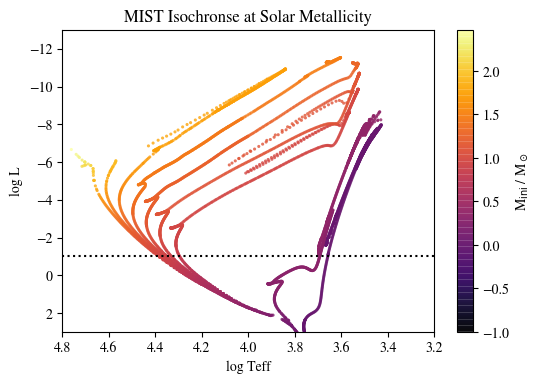

In [5]:
log_ages=[10,9,7.47,7.2,7.0,6.8,6.6,6.4,6.2] # Choose Isochrone Ages. 7.47 corresponds to 30Myr = Lifetime of 8Msun star
all_logt=[]
all_w1=[]
all_mini=[]
all_logl=[]
for age in log_ages:
    age_ind = isocmd.age_index(age) #returns the index for the desired age
    # Remove Pre MS and post AGB phases
    mask=(isocmd.isocmds[age_ind]['phase'] > -1) & (isocmd.isocmds[age_ind]['phase'] < 6)
    all_logl.extend(isocmd.isocmds[age_ind]['log_L'][mask])
    all_mini.extend(isocmd.isocmds[age_ind]['initial_mass'][mask])
    all_w1.extend(isocmd.isocmds[age_ind]['WISE_W1'][mask])
    all_logt.extend(isocmd.isocmds[age_ind]['log_Teff'][mask])
plt.scatter(all_logt,all_w1,s=5,c=np.log10(all_mini),cmap='inferno',edgecolor='',alpha=0.8) #GnBu # PuRd # BuPu
plt.axhline(y=-1, color='black', linestyle=':')
plt.axis([4.8, 3.2, 3, -13])
plt.xlabel('log Teff')
plt.ylabel('log L')
plt.title('MIST Isochronse at Solar Metallicity')
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'M$_{\rm ini}$ / M$_\odot$')
Mask=(isocmd.isocmds[10]['phase'] > -1)
L=isocmd.isocmds[10]['log_L']

## Get the data from GAIA DR2 
### ADQL Query (thanks to Alcione Mora and Hans-Walter Rix)

```
select
phot_g_mean_mag + 5 * log10(parallax) - 10 AS g_abs,
w1mpro + 5 * log10(parallax) - 10 AS w1_abs,
*
from gaiadr2.gaia_source as gaia
join gaiadr2.allwise_best_neighbour as xm
  on gaia.source_id = xm.source_id 
join gaiadr1.allwise_original_valid as wise
  on xm.allwise_oid = wise.allwise_oid
where w1mpro + 5 * log10(parallax) - 10 < -1
and phot_g_mean_mag - w1mpro < 1.5
and w2mpro - w3mpro between -0.4 and 0.2
and parallax_over_error >= 10

```

### We have applied the following cuts:

- Wise mag < -1 (This is suggested by looking at Isochrones)
- phot_g_mean_mag - w1mpro < 1.5
- w2mpro - w3mpro between -0.4 and 0.2
- parallax_over_error >= 10



Had to remove duplicate columns (using Topcat) and then converted fits -> hdf5 using vaex command line:

```vaex convert file FILENAME.fits FILENAME.hdf5```



## Load the data using VAEX

In [6]:
ds = vx.open('ALLWISEColorCut.hdf5')

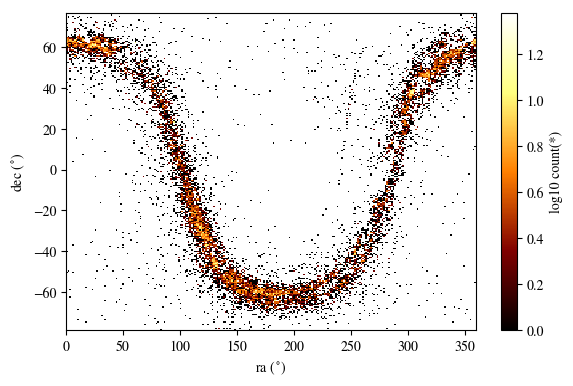

In [7]:
ds.get_column_names()
ds.plot("ra", "dec", f="log10")

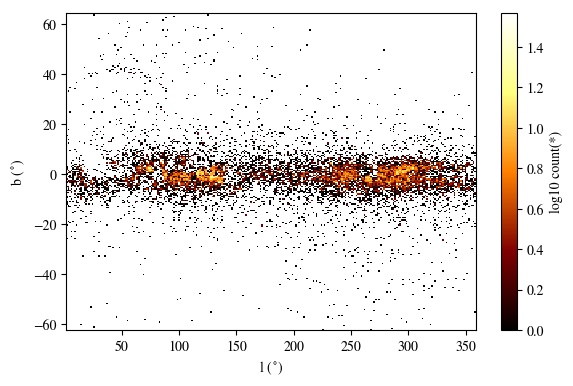

In [8]:
ds.plot("l", "b",f="log10")

In [9]:
w1_abs=ds.data.w1_abs
parallax=ds.data.parallax
pmra=ds.data.pmra
pmdec=ds.data.pmdec
ra=ds.data.ra
dec=ds.data.dec
pmra_error=ds.data.pmra_error
pmdec_error=ds.data.pmdec_error
bb=ds.data.b
ll=ds.data.l
bp_rp=ds.data.bp_rp
teff_val=ds.data.teff_val

## Transform proper motion to galactic coordinates (we want $\mu_b$)

In [10]:
sc = SkyCoord(u.deg*(ra), u.deg*(dec), pm_ra_cosdec=pmra*u.mas/u.yr, pm_dec=pmdec*u.mas/u.yr)
mu_b = sc.galactic.pm_b.value*1.0/parallax/(206265.0*1000.0)/(525600*60)*3e21/(1e5)

[-0.5, 3.2, -80, 80]

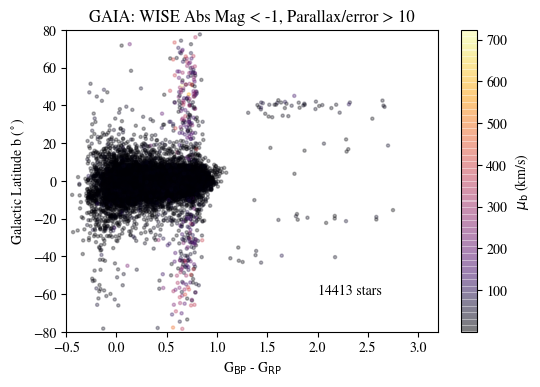

In [11]:
plt.scatter(bp_rp,bb,c=np.abs(mu_b),s=5, alpha=0.3,cmap='inferno')
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'$\mu_{\rm b}$ (km/s)')
plt.ylabel(r'Galactic Latitude b ($^{\circ}$)')
plt.xlabel(r'G$_{\rm BP}$ - G$_{\rm RP}$')
plt.annotate(str(len(bp_rp))+' stars',(2,-60))
plt.title(r'GAIA: WISE Abs Mag < -1, Parallax/error > 10')
plt.axis([-0.5, 3.2, -80, 80])
#plt.savefig(FILENAME)

## Cut in vertical velocity

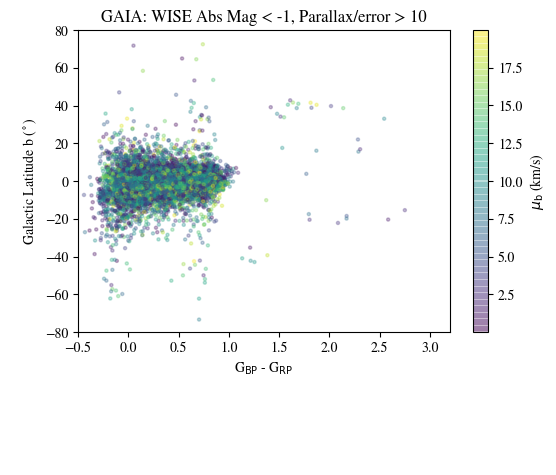

In [12]:
vmax = 20 # km/sprint(np.abs(mu_b))

nmu_b = mu_b[np.abs(mu_b) < vmax]
nbb   = bb[np.abs(mu_b) < vmax]
nll   = ll[np.abs(mu_b) < vmax]
nbp_rp = bp_rp[np.abs(mu_b) < vmax]
rr = parallax[np.abs(mu_b) < vmax]
w1abs = w1_abs[np.abs(mu_b) < vmax]
nteff_val = teff_val[np.abs(mu_b) < vmax]
nra=ra[np.abs(mu_b) < vmax]
ndec=dec[np.abs(mu_b) < vmax]


plt.scatter(nbp_rp,nbb,c=np.abs(nmu_b),s=5, alpha=0.3)
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'$\mu_{\rm b}$ (km/s)')
plt.ylabel(r'Galactic Latitude b ($^{\circ}$)')
plt.xlabel(r'G$_{\rm BP}$ - G$_{\rm RP}$')
plt.annotate(str(len(nbp_rp))+' stars',(7,-80))
plt.title(r'GAIA: WISE Abs Mag < -1, Parallax/error > 10')
plt.axis([-0.5, 3.2, -80, 80])
FILENAME = "GAIA_MASSIVE_WISECUTS.pdf"
plt.savefig(FILENAME)

## CMD 

Text(0,0.5,'WISE1 Abs Magnitude')

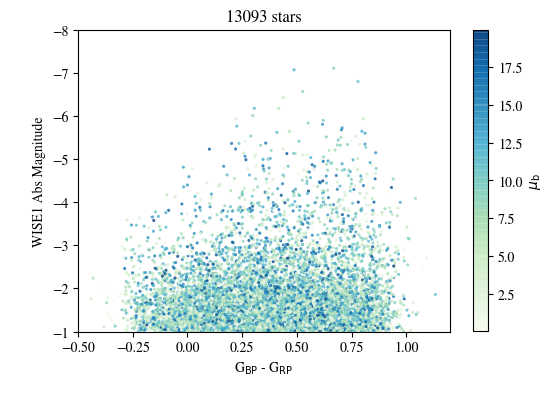

In [13]:
plt.scatter(nbp_rp,w1abs,s=5,c=np.abs(nmu_b),cmap='GnBu',edgecolor='',alpha=0.8) #GnBu # PuRd # BuPu
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'$\mu_{\rm b}$')
plt.title(str(len(nbp_rp))+' stars')

#plt.xlim(-0.5,1.5)
#plt.xlim(0, 1.8)
plt.axis([-0.5, 1.2, -1.0, -8])
#plt.xlim(0,3)
plt.annotate(str(len(nbp_rp))+' stars',(7,-9.5))
plt.xlabel(r'G$_{\rm BP}$ - G$_{\rm RP}$')
plt.ylabel(r'WISE1 Abs Magnitude')

## Cut in Galactic Latitude

In [14]:
bmax = 20 # degrees
b_   = nbb[np.abs(nbb) < bmax]
bp_rp_ = nbp_rp[np.abs(nbb) < bmax]
mu_b_ = nmu_b[np.abs(nbb) < bmax]
mnll_   = nll[np.abs(nbb) < bmax]
par_ = rr[np.abs(nbb) < bmax]
mw1_ = w1abs[np.abs(nbb) < bmax]
mteff_val = nteff_val[np.abs(nbb) < bmax]
mra=nra[np.abs(nbb) < vmax]
mdec=ndec[np.abs(nbb) < vmax]

print(len(nbb),len(b_))

13093 12817


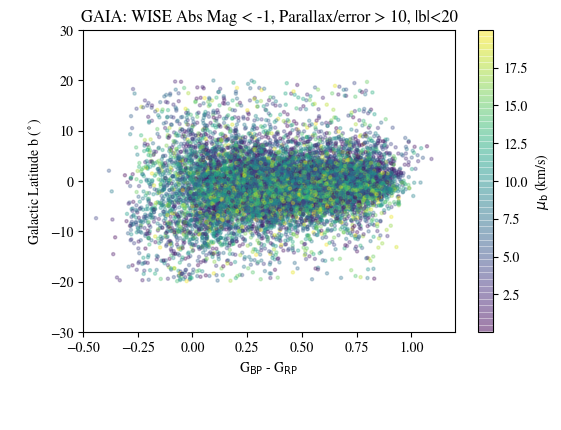

In [15]:
plt.scatter(bp_rp_,b_,c=np.abs(mu_b_),s=5, alpha=0.3)
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'$\mu_{\rm b}$ (km/s)')
plt.ylabel(r'Galactic Latitude b ($^{\circ}$)')
plt.xlabel(r'G$_{\rm BP}$ - G$_{\rm RP}$')
plt.annotate(str(len(nbp_rp))+' stars',(2,-35))
plt.title(r'GAIA: WISE Abs Mag < -1, Parallax/error > 10, |b|<20')
plt.axis([-0.5, 1.2, -30, 30])
FILENAME = "GAIA_MASSIVE_WISECUTS_B.pdf"
plt.savefig(FILENAME)

Text(0,0.5,'WISE1 Abs Magnitude')

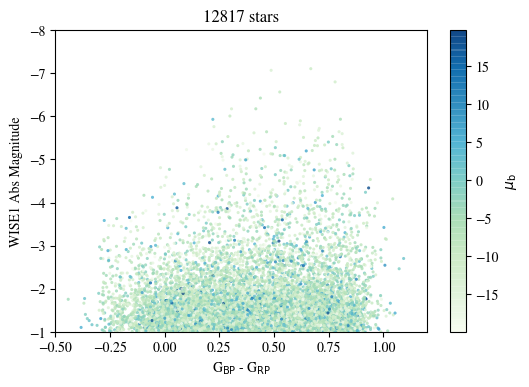

In [16]:
plt.scatter(bp_rp_,mw1_,s=5,c=mu_b_,cmap='GnBu',edgecolor='',alpha=0.8) #GnBu # PuRd # BuPu
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'$\mu_{\rm b}$')
plt.title(str(len(bp_rp_))+' stars')

#plt.xlim(-0.5,1.5)
#plt.xlim(0, 1.8)
plt.axis([-0.5, 1.2, -1.0, -8])
#plt.xlim(0,3)
plt.xlabel(r'G$_{\rm BP}$ - G$_{\rm RP}$')
plt.ylabel(r'WISE1 Abs Magnitude')

## Recap: We have applied the following cuts (first four come from ADQL query):
- Wise mag < -1
- phot_g_mean_mag - w1mpro < 1.5
- w2mpro - w3mpro between -0.4 and 0.2
- parallax_over_error >= 10
- Cut in |b| < 20
- Cut in |$\mu_b$| < 20 km/s


And then we can  e.g. plot l, b, d=1/parallax 

## Transform to galactic coordinates and plot cartesian representation 

In [17]:
sc2 = coord.SkyCoord(ra=mra* u.degree,dec=mdec* u.degree,
                     distance=coord.Distance(parallax=u.mas*par_))

Text(0,0.5,'W1 Mag')

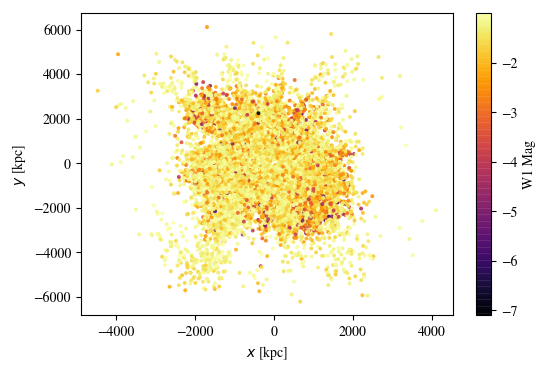

In [18]:
sc2 = sc2.transform_to(coord.Galactic)
sc2.set_representation_cls('cartesian')

plt.scatter(sc2.u, sc2.v,s=8,c=mw1_,cmap='inferno',edgecolor='',alpha=0.9)
plt.xlabel('$x$ [kpc]')
plt.ylabel('$y$ [kpc]')
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'W1 Mag')


Text(0,0.5,'W1 Mag')

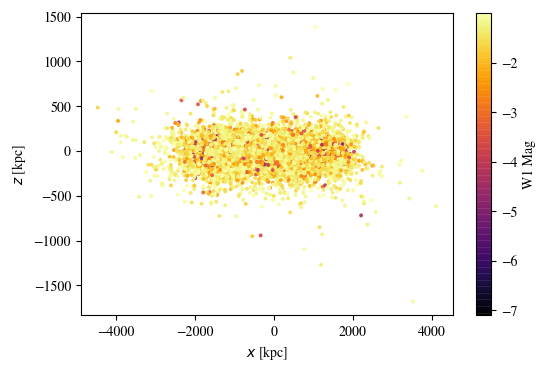

In [19]:
plt.scatter(sc2.u, sc2.w,s=8,c=mw1_,cmap='inferno',edgecolor='',alpha=0.9)
plt.xlabel('$x$ [kpc]')
plt.ylabel('$z$ [kpc]')
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'W1 Mag')

Text(0,0.5,'W1 Mag')

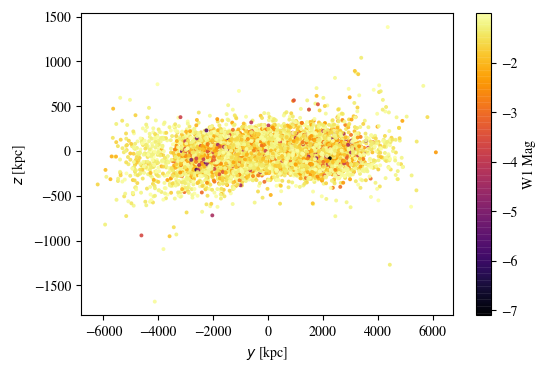

In [20]:
plt.scatter(sc2.v, sc2.w,s=8,c=mw1_,cmap='inferno',edgecolor='',alpha=0.9)

plt.xlabel('$y$ [kpc]')
plt.ylabel('$z$ [kpc]')
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'W1 Mag')

In [21]:
# Save data for ViZ with 
ar = np.array(mra)
dec =np.array(mdec)
np.savetxt('data.txt',(mra,mdec),fmt='%d')

# Vizualization produced using Partiview
### Thanks to Jonathan Gagné and Jackie Faherty
The color scheme represents stellar colors (in some range). Some OB association have been added as shaded blobs, as well as a galactic background model. 
Better watched full screen, settings: speed 0.5 and quality 720p60

In [23]:

from IPython.display import HTML
# Youtube Video
HTML('<iframe width="800" height="600" src="https://www.youtube.com/embed/jY-2towHHaY" frameborder="0" allowfullscreen></iframe>')